## Coursera Capstone - Week 4 & 5 - Battle of the Neighbourhoods

In [3]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


In [3]:
import pandas as pd
import numpy as np
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

! pip install folium==0.5.0
import folium 

import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

!pip install bs4
!pip install lxml
!pip install html5lib

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 79 kB 12.7 MB/s eta 0:00:01
  Created wheel for folium: file

# Introduction/Business Problem

Company ABC is looking to open it's first US office, in a major metropoliatain area.

The company needs a highly skilled and happy workforce. 

The company's workforce love pizza places, gyms, coffee shops and wine bars. This frequency of these locations will be the proxy for a happy workforce.

We will leverage the foursquare API to rank these items by city. 

We will build a regression model to help the company decide where to open the US office. There should be a link between the number of pizza places, gyms, coffee shops and wine bars (the independent variables), and per captia income (the dependent variable) which we will use as a proxy for a highly skilled workforce.

We will test multiple models to see which has the strongest link with capita income - pizza places, gyms, coffee shops and wine bars?

# Data

We wil leverage the foursquare API for the top 20 cities by per capita income.

In order to do this we will pull the city lat long from from geopy.geocoders Nominatim module, to convert an address into latitude and longitude values (see section 3 data)

We will pull back data on the number of art galleries, gyms, coffee shops and wine bars by city.

## 1. Average Income by Cities (top 10)

Average Per Capita income by US City

https://en.wikipedia.org/wiki/List_of_United_States_metropolitan_areas_by_per_capita_income

Source: US 2010 Census

### 1.1 Example data

In [52]:
url2= 'https://en.wikipedia.org/wiki/List_of_United_States_metropolitan_areas_by_per_capita_income'
html_content = requests.get(url2).text

dfs = pd.read_html(html_content)

df = dfs[2]
df = df.head(10)
df

,Rank,Metropolitan statistical area,Population,Per capitaincome
0,1,"Washington-Arlington-Alexandria, D.C-Virginia-...",5949178,"$47,411"
1,2,"San Jose-Santa Clara-Sunnyvale, California MSA",1918944,"$40,392"
2,3,"Seattle-Tacoma-Bellevue, Washington MSA",3611644,"$39,322"
3,4,"San Francisco-Oakland-Hayward, California MSA",4122177,"$38,355"
4,5,"Boston–Worcester–Lawrence, Massachusetts–New H...",5819100,"$37,311"
5,6,"Honolulu, Hawaii MSA",921000,"$36,339"
6,7,"Minneapolis-St. Paul-Bloomington, Minnesota MSA",3478415,"$35,388"
7,8,"Hartford, Connecticut MSA",1183110,"$34,310"
8,9,"Denver-Aurora-Lakewood, Colorado MSA",2871068,"$32,399"
9,10,"Portland-Vancouver-Hillsboro, Oregon MSA",2345318,"$31,377"


In [53]:
data = [['Washington, DC', 47411], ['San Jose, CA', 40392], ['Seattle, WA', 39322], ['San Francisco, CA', 38355], ['Boston, MA', 37311], ['Honolulu, HI', 36339], ['Minneapolis, Minnesota', 35388], ['Hartford, CT', 34310], ['Denver, CO', 32399], ['Portland, OR', 31377]]

df = pd.DataFrame(data, columns = ['City', 'IncomeCapita'])

df

,City,IncomeCapita
0,"Washington, DC",47411
1,"San Jose, CA",40392
2,"Seattle, WA",39322
3,"San Francisco, CA",38355
4,"Boston, MA",37311
5,"Honolulu, HI",36339
6,"Minneapolis, Minnesota",35388
7,"Hartford, CT",34310
8,"Denver, CO",32399
9,"Portland, OR",31377


## 2. Lat Long data

We will use geopy.geocoders Nominatim module, to convert each city into latitude and longitude values

### 2.1 Example data

In [54]:
address = 'Washington, DC'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Washington, DC are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Washington, DC are 38.8949924, -77.0365581.


## 3. Foursquare location data

### 3.1 Example data

In [7]:
CLIENT_ID = 'YV4QTJAQ3F1OGZG2AFPTE5SEPY02PS3CLHHK35VXRDDQE3WZ' # your Foursquare ID
CLIENT_SECRET = 'JSWHMGPW210QWZQSYEBQEDLZK3OS2XXZQ0KA22O4AYBNLXI4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YV4QTJAQ3F1OGZG2AFPTE5SEPY02PS3CLHHK35VXRDDQE3WZ
CLIENT_SECRET:JSWHMGPW210QWZQSYEBQEDLZK3OS2XXZQ0KA22O4AYBNLXI4


Prepare the URL to pass to the API:

In [55]:
radius = 10000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=YV4QTJAQ3F1OGZG2AFPTE5SEPY02PS3CLHHK35VXRDDQE3WZ&client_secret=JSWHMGPW210QWZQSYEBQEDLZK3OS2XXZQ0KA22O4AYBNLXI4&ll=38.8949924,-77.0365581&v=20180605&radius=10000&limit=100'

Pass the get request for the json results file

In [130]:
results = requests.get(url).json()
#results

### Extract the category of the venue

In [57]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Clean and collate json data

In [58]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,categories,lat,lng
0,History Museum,38.891171,-77.032818
1,Hotel,38.897215,-77.032541
2,Hotel,38.900510,-77.036885
3,Monument / Landmark,38.889377,-77.040516
4,American Restaurant,38.897954,-77.033270
5,Coffee Shop,38.898073,-77.031991
6,History Museum,38.890874,-77.032535
7,History Museum,38.891213,-77.030030
8,Seafood Restaurant,38.899984,-77.033939
9,Hotel,38.900478,-77.034006



#### We will combine all the above data for the regression model for ABC company.

# Methodology 

In [21]:
# discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

## 1. Loop through cities to assign lat long

In [59]:
addresses = df['City'].values.tolist()
geolocator = Nominatim(user_agent="ny_explorer")

latitudes = []
longitudes = []
for address in addresses: 
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude

    
    latitudes.append(latitude) 
    longitudes.append(longitude)

In [60]:
dfLat = pd.DataFrame({'Lat':latitudes})
dfLong = pd.DataFrame({'Long':longitudes})
df = pd.concat([df, dfLat], axis=1)
df = pd.concat([df, dfLong], axis=1)
df

,City,IncomeCapita,Lat,Long
0,"Washington, DC",47411,38.894992,-77.036558
1,"San Jose, CA",40392,37.336191,-121.890583
2,"Seattle, WA",39322,47.603832,-122.330062
3,"San Francisco, CA",38355,37.779026,-122.419906
4,"Boston, MA",37311,42.360253,-71.058291
5,"Honolulu, HI",36339,21.304547,-157.855676
6,"Minneapolis, Minnesota",35388,44.977300,-93.265469
7,"Hartford, CT",34310,41.765558,-72.690613
8,"Denver, CO",32399,5.342848,-72.395985
9,"Portland, OR",31377,45.520247,-122.674195


## 2. Pass lat longs to foursquare API

In [61]:
    
venues_list=[]
for name, lat, lng, inc in zip(df['City'], df['Lat'], df['Long'], df['IncomeCapita']):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            inc,
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

nearby_venues2 = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues2.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'IncomeCapita',
                  'Venue', 
                  'Venue Category']
    

## Foursquare Results

In [62]:
nearby_venues2

,City,Latitude,Longitude,IncomeCapita,Venue,Venue Category
0,"Washington, DC",38.894992,-77.036558,47411,National Museum of African American History an...,History Museum
1,"Washington, DC",38.894992,-77.036558,47411,The Willard InterContinental Washington D.C. H...,Hotel
2,"Washington, DC",38.894992,-77.036558,47411,The Hay-Adams,Hotel
3,"Washington, DC",38.894992,-77.036558,47411,World War II Memorial,Monument / Landmark
4,"Washington, DC",38.894992,-77.036558,47411,Old Ebbitt Grill,American Restaurant
...,...,...,...,...,...,...
933,"Portland, OR",45.520247,-122.674195,31377,Ox,Argentinian Restaurant
934,"Portland, OR",45.520247,-122.674195,31377,Meat for Cats & Dogs,Pet Store
935,"Portland, OR",45.520247,-122.674195,31377,St. Honoré Boulangerie,Café
936,"Portland, OR",45.520247,-122.674195,31377,International Rose Test Garden,Botanical Garden


In [72]:
#Let's check how many venues were returned for each neighborhood

nearby_venues2.groupby('City').count()


,Latitude,Longitude,IncomeCapita,Venue,Venue Category
City,,,,,
"Boston, MA",100,100,100,100,100
"Denver, CO",38,38,38,38,38
"Hartford, CT",100,100,100,100,100
"Honolulu, HI",100,100,100,100,100
"Minneapolis, Minnesota",100,100,100,100,100
"Portland, OR",100,100,100,100,100
"San Francisco, CA",100,100,100,100,100
"San Jose, CA",100,100,100,100,100
"Seattle, WA",100,100,100,100,100


## 3. One hot encoding

In [96]:
# one hot encoding
onehot = pd.get_dummies(nearby_venues2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
#onehot['IncomeCapita'] = nearby_venues2['IncomeCapita'] 
onehot['City'] = nearby_venues2['City'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()
#onehot.loc[onehot['City'] == 'Denver, CO']

,City,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Toy / Game Store,Trail,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo
0,"Washington, DC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Washington, DC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Washington, DC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Washington, DC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Washington, DC",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Final output of counts of venues

In [104]:

grouped = onehot.groupby('City').sum().reset_index()
grouped

venues_grouped = pd.merge(grouped, df, on=["City"])
venues_grouped.head(10)

,City,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio,Zoo,IncomeCapita,Lat,Long
0,"Boston, MA",0,3,0,1,0,0,0,0,1,...,0,0,0,1,1,0,0,37311,42.360253,-71.058291
1,"Denver, CO",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,32399,5.342848,-72.395985
2,"Hartford, CT",0,8,0,0,0,1,1,2,0,...,0,2,0,1,0,1,0,34310,41.765558,-72.690613
3,"Honolulu, HI",0,1,0,0,0,0,1,0,0,...,1,2,0,1,0,0,0,36339,21.304547,-157.855676
4,"Minneapolis, Minnesota",0,2,1,0,0,2,1,0,2,...,0,4,0,0,0,0,0,35388,44.977300,-93.265469
5,"Portland, OR",0,1,0,0,1,0,1,0,0,...,1,2,0,0,0,1,0,31377,45.520247,-122.674195
6,"San Francisco, CA",1,0,0,0,0,0,3,1,0,...,0,0,0,2,1,5,0,38355,37.779026,-122.419906
7,"San Jose, CA",0,0,0,0,0,1,0,0,1,...,3,3,0,0,0,1,1,40392,37.336191,-121.890583
8,"Seattle, WA",0,0,0,0,0,0,2,0,0,...,0,4,1,1,0,3,0,39322,47.603832,-122.330062
9,"Washington, DC",0,4,0,0,0,0,5,0,1,...,1,0,1,2,1,0,0,47411,38.894992,-77.036558


## 4. Fit regression model

In [105]:
# Remove columns to keep only our 4 venue categories
df2 = venues_grouped[['City', 'Pizza Place', 'Coffee Shop', 'Gym', 'Wine Bar', 'IncomeCapita']]

df2.rename(columns={'Pizza Place': 'PizzaPlace', 'Coffee Shop': 'CoffeeShop', 'Wine Bar': 'WineBar'}, inplace=True)
df2.head(10)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,City,PizzaPlace,CoffeeShop,Gym,WineBar,IncomeCapita
0,"Boston, MA",2,4,0,1,37311
1,"Denver, CO",3,0,2,0,32399
2,"Hartford, CT",5,2,1,1,34310
3,"Honolulu, HI",2,4,1,1,36339
4,"Minneapolis, Minnesota",4,3,2,0,35388
5,"Portland, OR",2,8,0,0,31377
6,"San Francisco, CA",2,9,2,2,38355
7,"San Jose, CA",4,2,1,0,40392
8,"Seattle, WA",2,6,1,1,39322
9,"Washington, DC",0,3,0,2,47411


### 4.1 Pizza places - try a linear model

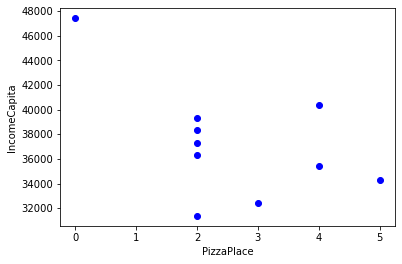

In [106]:
plt.scatter(df2.PizzaPlace, df2.IncomeCapita,  color='blue')
plt.xlabel("PizzaPlace")
plt.ylabel("IncomeCapita")
plt.show()

### Pizza place may have a negative linear correllation 

In [112]:
# Train / test split 

msk = np.random.rand(len(df)) < 0.8
train = df2[msk]
test = df2[~msk]

In [127]:
# fit the model

from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['PizzaPlace']])
y = np.asanyarray(train[['IncomeCapita']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[-1587.90909091]]


In [128]:
# make a prediction & score

y_hat= regr.predict(test[['PizzaPlace']])
x = np.asanyarray(test[['PizzaPlace']])
y = np.asanyarray(test[['IncomeCapita']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 10911919.61
Variance score: 0.09


### A model was fitted, but it only explains 9% of the variance.

Text(0, 0.5, 'IncomeCapita')

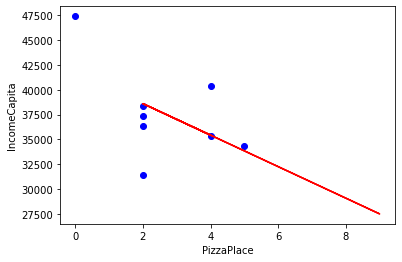

In [129]:
# plot the model to assess visually

plt.scatter(train.PizzaPlace, train.IncomeCapita,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("PizzaPlace")
plt.ylabel("IncomeCapita")

## Let's try coffee shops

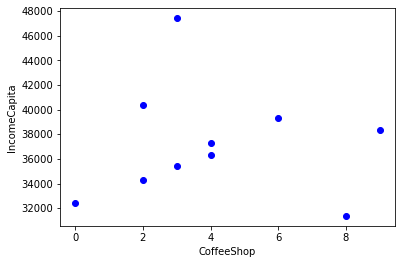

In [107]:
# assess visually

plt.scatter(df2.CoffeeShop, df2.IncomeCapita,  color='blue')
plt.xlabel("CoffeeShop")
plt.ylabel("IncomeCapita")
plt.show()

## Coffee shop may have a polynomial relationship

In [117]:
# split the data, set up the model

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
train_x = np.asanyarray(train[['CoffeeShop']])
train_y = np.asanyarray(train[['IncomeCapita']])

test_x = np.asanyarray(test[['CoffeeShop']])
test_y = np.asanyarray(test[['IncomeCapita']])

poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(train_x)
train_x_poly

array([[ 1.,  4., 16.],
       [ 1.,  2.,  4.],
       [ 1.,  4., 16.],
       [ 1.,  3.,  9.],
       [ 1.,  8., 64.],
       [ 1.,  9., 81.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.]])

In [118]:
# fit the model

clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[    0.         -1327.16867328    69.78245987]]
Intercept:  [41646.00802644]


Text(0, 0.5, 'IncomeCapita')

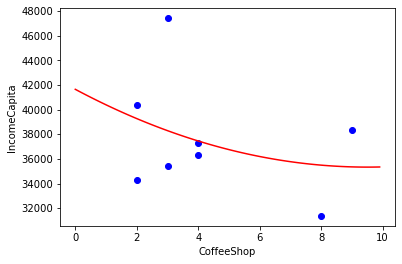

In [119]:
# plot the model to assess visually

plt.scatter(train.CoffeeShop, train.IncomeCapita,  color='blue')
XX = np.arange(0.0, 10.0, 0.1)
yy = clf.intercept_[0]+ clf.coef_[0][1]*XX+ clf.coef_[0][2]*np.power(XX, 2)
plt.plot(XX, yy, '-r' )
plt.xlabel("CoffeeShop")
plt.ylabel("IncomeCapita")

### The model is fitted but it is not a good predictor:

In [124]:
from sklearn.metrics import r2_score

test_x_poly = poly.fit_transform(test_x)
test_y_ = clf.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y,test_y_ ) )


Mean absolute error: 6186.92
Residual sum of squares (MSE): 47642128.71
R2-score: -2.98


### The model is not a good fit - the r squared score is negative - there is no relationship

# Results 

Both models are quite terrible predictors of per capita income.

The model predicts income decreases as pizza places increase. Pizza places only explain 9% of the variance in capita income.

The model has fitted to coffee shops but the R Squared is negative, meaning there is no correllation.

There are not enough data points on gyms and wine bars to perform the analysis.


# Discussion 

We have fitted one model with some skill, which predicts lower number of pizza places gives higer capita income.

Of course correllation does not imply causation!

The analysis is very limited by the 100 limit on the foursquare API, which does not give enough results for each venue type to build a good model.

Recommend ABC company to pay for the developer level API so that they can get better results :)

# Conclusion 

ABC Company should open their US office in Washington, DC, as it has 0 pizza places.

Good luck!